In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import os
import glob
import numpy as np
from typing import Iterable
import pickle
from tqdm.notebook import tqdm
import tensorflow as tf
from scipy.fft import fft, ifft
from statsmodels.tsa.stattools import acf, pacf
from sklearn.decomposition import PCA

import keras
import keras_tuner as kt
from kerastuner import RandomSearch
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras import regularizers

2023-12-21 14:18:44.708418: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/9z/qyx6tbz50h702rhr6ydchnfc0000gn/T/ipykernel_2335/1377748196.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch
/Users/kaanucar/Desktop/ml-project-2-nuclear-fusion/venv/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more in

In [5]:
# load a single shot using pandas parquet file reader 
def load_shot(shotnum: int) -> pd.DataFrame:
    shot = pd.read_parquet("../data/DISR_data/JET_DATAno" + str(shotnum) + ".parquet")
    return shot

shotnum = 97974
df_shot = load_shot(shotnum)
df_shot['IPE'] = df_shot['IPLA'] - df_shot['IPref']
display(df_shot)

,time,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,IPE
0,0.028000,-52848.476562,-0.030766,594.211243,0.003052,0.560703,14.721497,-0.031971,-13.021408,-52848.445312
1,0.029000,-54610.519531,-0.030766,594.211243,0.002289,0.560703,14.721497,-0.031971,-13.539573,-54610.488281
2,0.030000,-56940.988281,-0.030766,594.211243,0.003052,0.560703,14.721497,-0.031971,-13.380624,-56940.957031
3,0.031000,-59598.527344,-0.030766,594.211243,0.002747,0.560703,14.721497,-0.031971,-13.339972,-59598.496094
4,0.032000,-62124.882812,-0.030766,594.211243,0.002899,0.560703,14.721497,-0.031971,-12.703513,-62124.851562
...,...,...,...,...,...,...,...,...,...,...
19434,19.462000,-87571.187500,-0.030766,7.806218,0.003357,0.906932,3.333023,0.207200,-69.351303,-87571.156250
19435,19.462999,-78724.585938,-0.030766,7.806218,0.002899,0.906932,3.333023,0.207200,-59.505859,-78724.554688
19436,19.464001,-70535.187500,-0.030766,7.806218,0.003204,0.906932,3.333023,0.207200,-52.169930,-70535.156250
19437,19.465000,-65536.421875,-0.030766,7.806218,0.002136,0.906932,3.333023,0.207200,-45.075916,-65536.390625


In [30]:
# Load model and prepare df_shot as before
model = tf.keras.models.load_model("../models/nn_window.keras")

window_size = 20
label_count = 15

# Initialize variables
window = 0
window_cursor_one = 0
window_cursor_two = window_size - 1

# Add required columns
df_shot['Instability'] = 0
df_shot['Window'] = window
df_shot['Label'] = -1

for i in tqdm(range(len(df_shot)), desc='Processing samples'):
    # Ensure there are enough samples to form a complete window
    if i + window_size > len(df_shot):
        break  # Skip if not enough samples for a complete window

    sample = df_shot.iloc[i]
    prediction = model.predict(np.array([sample]))[0]
    label = np.argmax(prediction)

    df_shot.loc[i, 'Label'] = label

    # Check if window_cursor_two has reached the window size
    if i == window_cursor_two:
        max_label = df_shot['Label'].iloc[window_cursor_one : window_cursor_two + 1].value_counts().max()

        if max_label >= label_count and max_label != -1:
            window += 1
            df_shot.loc[window_cursor_one : window_cursor_two, 'Window'] = window

            if label == 1:
                df_shot.loc[i + 1:, 'Instability'] += 1
            
            # Move the window cursors to the next window
            window_cursor_one += window_size
            window_cursor_two += window_size
        else:
            # Slide the window cursors by 1
            window_cursor_one += 1
            window_cursor_two += 1

# Display the updated DataFrame
display(df_shot)

Processing samples:   0%|          | 0/19439 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


,time,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,IPE,Instability,Window,Label
0,0.028000,-52848.476562,-0.030766,594.211243,0.003052,0.560703,14.721497,-0.031971,-13.021408,-52848.445312,0,1,0
1,0.029000,-54610.519531,-0.030766,594.211243,0.002289,0.560703,14.721497,-0.031971,-13.539573,-54610.488281,0,1,0
2,0.030000,-56940.988281,-0.030766,594.211243,0.003052,0.560703,14.721497,-0.031971,-13.380624,-56940.957031,0,1,0
3,0.031000,-59598.527344,-0.030766,594.211243,0.002747,0.560703,14.721497,-0.031971,-13.339972,-59598.496094,0,1,0
4,0.032000,-62124.882812,-0.030766,594.211243,0.002899,0.560703,14.721497,-0.031971,-12.703513,-62124.851562,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19434,19.462000,-87571.187500,-0.030766,7.806218,0.003357,0.906932,3.333023,0.207200,-69.351303,-87571.156250,919,0,-1
19435,19.462999,-78724.585938,-0.030766,7.806218,0.002899,0.906932,3.333023,0.207200,-59.505859,-78724.554688,919,0,-1
19436,19.464001,-70535.187500,-0.030766,7.806218,0.003204,0.906932,3.333023,0.207200,-52.169930,-70535.156250,919,0,-1
19437,19.465000,-65536.421875,-0.030766,7.806218,0.002136,0.906932,3.333023,0.207200,-45.075916,-65536.390625,919,0,-1


In [32]:
windows = df_shot[df_shot['Label'] == 1]['Window'].unique()

display(df_shot[df_shot['Window'] == windows[19]])

,time,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,IPE,Instability,Window,Label
1147,1.175,-548496.7500,-729347.5000,685.438416,0.003204,1.271434,8.693477,0.226738,-2.707448,180850.7500,19,58,1
1148,1.176,-549080.6250,-733239.3750,692.095337,0.003357,1.271434,8.693477,0.226738,-3.105651,184158.7500,19,58,1
1149,1.177,-550312.3125,-733239.3750,691.878845,0.002441,1.271434,8.693477,0.226738,-2.548833,182927.0625,19,58,1
1150,1.178,-549770.1875,-733239.3750,691.878845,0.002899,1.271434,8.693477,0.226738,-2.350231,183469.1875,19,58,1
1151,1.179,-551200.5000,-733239.3750,693.083984,0.002747,1.271434,8.693477,0.226738,-2.907049,182038.8750,19,58,1
1152,1.180,-550781.9375,-733239.3750,693.657471,0.003052,1.271434,8.693477,0.226738,-2.549833,182457.4375,19,58,1
1153,1.181,-551148.3125,-733239.3750,694.510559,0.002136,1.271434,8.693477,0.226738,-3.424880,182091.0625,19,58,1
1154,1.182,-549364.3750,-733239.3750,693.112061,0.002594,1.271434,8.693477,0.226738,-2.709114,183875.0000,19,58,1
1155,1.183,-550513.4375,-733239.3750,695.219299,0.001984,1.271434,8.693477,0.226738,-3.346239,182725.9375,19,58,1
1156,1.184,-551700.8125,-737131.2500,693.409302,0.002441,1.271434,8.693477,0.226738,-2.748767,185430.4375,19,58,1


In [35]:
# Filter out rows where 'Window' is 0
df_shot_filtered = df_shot[df_shot['Window'] != 0]

# Remove the 'Label' column
df_shot_modified = df_shot_filtered.drop(columns=['Label'])

print(f"Length of the processed shot : {len(df_shot_modified)}")

# Save the DataFrame as a csv file
df_shot_modified.to_csv("../data/pipeline" + str(shotnum) + ".csv", index=False)

Length of the processed shot : 19400


In [28]:
# The commented line below is needed to obtain results form the report.
# The data of the shot is in piepline.csv but we don't remember the shot number.
#shotnum = ""

# Load the DataFrame from the csv file
dataset = pd.read_csv("../data/pipeline" + str(shotnum) + ".csv")

# Rename the 'time' column to 'Time'
dataset.rename(columns={'time': 'Time'}, inplace=True)

# Drop the 'IPE' and 'Instability' columns and group the DataFrame by 'Window'
grouped = dataset.drop(columns=['IPE', 'Instability']).groupby('Window')

# Define columns to perform feature engineering on
columns = ['Time', 'IPLA', 'IPref', 'ECEcore', 'SSXcore', 'LI', 'Q95', 'ZMAG', 'Vloop']

# Define the operations to perform on each column
operations = {
    'fft_abs': lambda x: np.abs(np.fft.fft(x)),
    'der': np.gradient,
    'der2': lambda x: np.gradient(np.gradient(x))
}

df_data = pd.DataFrame()
window = 0

# Iterate over the groups
for name, group in grouped:
    # Create a DataFrame for the group
    df = pd.DataFrame(group.values, columns=group.columns)

    # Add the IPE column
    df['IPE'] = np.abs(df['IPLA'] - df['IPref'])

    # Perform feature engineering on each column
    new_cols = {}
    for col in columns:
        for op_name, op_func in operations.items():
            new_cols[col + '_' + op_name] = op_func(df[col])

    # Create a new DataFrame with the new columns
    df_new = pd.DataFrame(new_cols)

    # Concatenate the original DataFrame with the new one
    df = pd.concat([df, df_new], axis=1)

    # Add the Frame, Shot and Window columns
    df['Frame'] = range(0, 20)
    df['Shot'] = shotnum
    df['Window'] = window  # Add the window number
    window += 1

    contains_nan = df.isna().any().any()

    if not contains_nan:
        # Append the current DataFrame to the main DataFrame
        df_data = pd.concat([df_data, df], ignore_index=True)
    
    
df_data = df_data.dropna()
display(df_data)

,Time,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,Window,...,Q95_der,Q95_der2,ZMAG_fft_abs,ZMAG_der,ZMAG_der2,Vloop_fft_abs,Vloop_der,Vloop_der2,Frame,Shot
0,0.022,-53160.492,0.022461,1141.5006,0.002289,0.661752,10.408838,0.020125,-17.961126,0,...,0.0,0.0,0.402509,0.0,0.0,353.277136,0.318895,-0.458016,0,
1,0.023,-56066.082,0.022461,1141.5006,0.001373,0.661752,10.408838,0.020125,-17.642231,0,...,0.0,0.0,0.000000,0.0,0.0,3.339015,-0.139121,-0.298902,1,
2,0.024,-59827.996,0.022461,1141.5006,0.000916,0.661752,10.408838,0.020125,-18.239368,0,...,0.0,0.0,0.000000,0.0,0.0,0.318748,-0.278909,0.179024,2,
3,0.025,-63139.010,0.022461,1141.5006,0.001679,0.661752,10.408838,0.020125,-18.200048,0,...,0.0,0.0,0.000000,0.0,0.0,1.357657,0.218928,0.219095,3,
4,0.026,-66272.710,0.022461,1141.5006,0.001221,0.661752,10.408838,0.020125,-17.801512,0,...,0.0,0.0,0.000000,0.0,0.0,1.179940,0.159281,-0.179274,4,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16875,16.897,-125845.310,0.022461,1224.4491,0.000763,1.155780,3.558453,0.329814,-106.415500,843,...,0.0,0.0,0.000000,0.0,0.0,100.534729,13.177520,-0.308229,15,
16876,16.898,-116508.960,0.022461,1224.4491,0.002747,1.155780,3.558453,0.329814,-93.338440,843,...,0.0,0.0,0.000000,0.0,0.0,114.099104,12.400278,-1.046492,16,
16877,16.899,-111078.960,0.022461,1224.4491,0.002594,1.155780,3.558453,0.329814,-81.614944,843,...,0.0,0.0,0.000000,0.0,0.0,154.818630,11.084535,-1.524588,17,
16878,16.900,-108135.440,0.022461,1224.4491,0.001526,1.155780,3.558453,0.329814,-71.169370,843,...,0.0,0.0,0.000000,0.0,0.0,257.682923,9.351102,-1.413953,18,


In [29]:
# Group by 'Window' and 'Shot', and reshape the data
new_data_grouped = df_data.sort_values(['Shot', 'Window', 'Time']).groupby(['Shot', 'Window'])

# Prepare a list to hold sequences
X_new_grouped = []

# Generate sequences for new data
for _, group in new_data_grouped:
    X_new_grouped.append(group.drop(columns=['Frame', 'Shot', 'Window']).values)

# Convert list to numpy array
X_new_grouped = np.array(X_new_grouped)

# Load the scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Normalize the features using the same scaler fitted on the training data
X_new = scaler.transform(X_new_grouped.reshape(-1, X_new_grouped.shape[-1])).reshape(X_new_grouped.shape)

In [30]:
X_new.shape

(844, 20, 37)

27/27 [==============================] - 1s 6ms/step


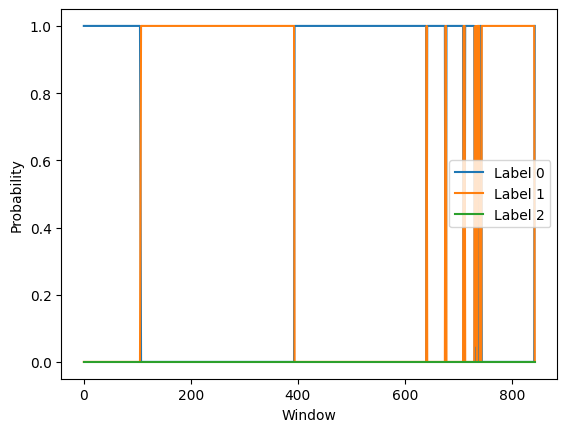

In [31]:
# Load the model
model = tf.keras.models.load_model("../models/resnet.keras")

# Perform predictions on the new data
predictions = model.predict(X_new)

# Get the number of labels
num_labels = predictions.shape[1]

# Create a new figure
plt.figure()

# Plot the probability for each label
for i in range(num_labels):
    plt.plot(df_data['Window'].unique(), predictions[:, i], label=f'Label {i}')

# Add a legend
plt.legend()

# Add labels for the x and y axes
plt.xlabel('Window')
plt.ylabel('Probability')

# Show the plot
plt.show()

In [32]:
# Get the probabilities for class 2
class_2_probs = predictions[:, 2]

# Get the rows where the probability for class 2 is greater than 0
rows = predictions[class_2_probs > 0]

print(f'Number of rows: {len(rows)}')

Number of rows: 0


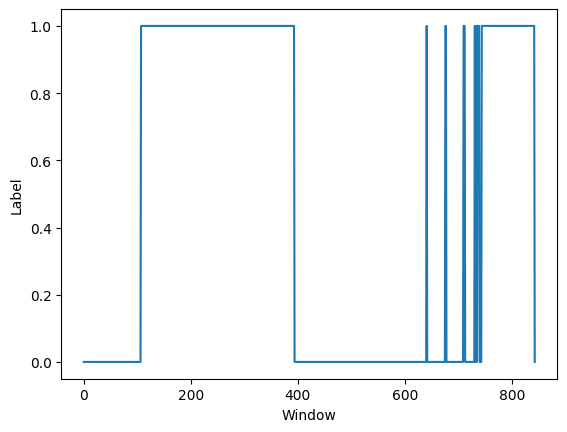

In [33]:
labels = []

for pred in predictions:
    if pred[2] > 0.2:
        labels.append(2)
    else:
        labels.append(np.argmax(pred))

# Get the unique windows
windows = df_data['Window'].unique()

# Create a new figure
plt.figure()

# Plot the labels with respect to the windows
plt.plot(windows, labels)

# Add labels for the x and y axes
plt.xlabel('Window')
plt.ylabel('Label')

# Show the plot
plt.show()


In [34]:
# Create a new DataFrame with the columns 'Window' and 'Label'
df_res = df_data[columns + ['Window']]

# Generate a mapping from window numbers to labels
window_label_mapping = dict(zip(windows, labels))

# Map the labels to the DataFrame
df_res['Predicted_Label'] = df_res['Window'].map(window_label_mapping)

# Display the DataFrame
display(df_res)


/var/folders/9z/qyx6tbz50h702rhr6ydchnfc0000gn/T/ipykernel_15104/3406723380.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['Predicted_Label'] = df_res['Window'].map(window_label_mapping)


,Time,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,Window,Predicted_Label
0,0.022,-53160.492,0.022461,1141.5006,0.002289,0.661752,10.408838,0.020125,-17.961126,0,0
1,0.023,-56066.082,0.022461,1141.5006,0.001373,0.661752,10.408838,0.020125,-17.642231,0,0
2,0.024,-59827.996,0.022461,1141.5006,0.000916,0.661752,10.408838,0.020125,-18.239368,0,0
3,0.025,-63139.010,0.022461,1141.5006,0.001679,0.661752,10.408838,0.020125,-18.200048,0,0
4,0.026,-66272.710,0.022461,1141.5006,0.001221,0.661752,10.408838,0.020125,-17.801512,0,0
...,...,...,...,...,...,...,...,...,...,...,...
16875,16.897,-125845.310,0.022461,1224.4491,0.000763,1.155780,3.558453,0.329814,-106.415500,843,0
16876,16.898,-116508.960,0.022461,1224.4491,0.002747,1.155780,3.558453,0.329814,-93.338440,843,0
16877,16.899,-111078.960,0.022461,1224.4491,0.002594,1.155780,3.558453,0.329814,-81.614944,843,0
16878,16.900,-108135.440,0.022461,1224.4491,0.001526,1.155780,3.558453,0.329814,-71.169370,843,0


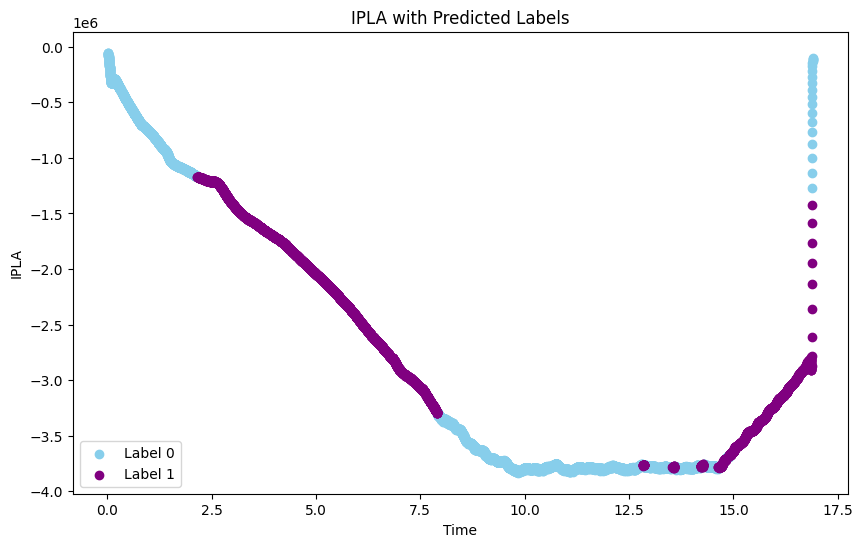

In [39]:
# Create a scatter plot
plt.figure(figsize=(10, 6))

# Define colors for each label: sky blue and pink
colors = ['skyblue', 'purple']  # Adjust as needed for the labels

# Plot each label with a different color
for label, color in zip(df_res['Predicted_Label'].unique(), colors):
    selected_data = df_res['Predicted_Label'] == label
    plt.scatter(df_res['Time'][selected_data], df_res['IPLA'][selected_data], c=color, label=f'Label {label}')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('IPLA')
plt.title('IPLA with Predicted Labels')

# Add a legend
plt.legend()

# Show the plot
plt.show()